In [1]:
import ray

ray.init()
    
try:
    ! nest-server start -o -d -p 52425
    RAY = False
except:
    RAY = True
    # TODO: Find out why we can't deamonize the NEST server...
    # For the moment we need to use Ray to deamonize it, or start it on a terminal.
    # ! nest-server start -o -p 52425

    import os
      # _temp_dir="/home/docker/tmp/ray", object_store_memory=100000000

    @ray.remote
    def start_deamonize_nest_server():
        os.system('! nest-server start -o -p 52425')

    # @ray.remote
    # def nest_server_status():
    #     os.system('! nest-server status')

    # @ray.remote
    # def nest_server_log():
    #     os.system('! nest-server log')

    start_deamonize_nest_server.remote()
    # nest_server_status.remote()
    # nest_server_log.remote()

In [3]:
from nest_client import NESTClient  # , requests  # encode,
import requests
from werkzeug.exceptions import BadRequest


def encode(response):
    if response.ok:
        return response.json()
    elif response.status_code == 400:
        raise BadRequest(response.text)
 

@ray.remote
def method(call, url, headers, *args, **kwargs):
    kwargs.update({'args': args})
    response = requests.post(url + 'api/' + call, json=kwargs, headers=headers)
    return encode(response)
     
    
@ray.remote
def exec_script(url, headers, source, return_vars=None):
    params = {
        'source': source,
        'return': return_vars,
    }
    response = requests.post(url + 'exec', json=params, headers=headers)
    return encode(response)


def from_file(url, headers, filename, return_vars=None):
    with open(filename, 'r') as f:
        lines = f.readlines()
        script = ''.join(lines)
        print('Execute script code of {}'.format(filename))
        print('Return variables: {}'.format(return_vars))
        print(20 * '-')
        print(script)
        print(20 * '-')
    return exec_script.remote(url, headers, script, return_vars)

@ray.remote
class RayRequest(object):
    host = 'localhost'
    port = 52425
    url = 'http://{}:{}/'.format('localhost', 52425)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    
    def __init__(self, host='localhost', port=52425):
        self.host = host
        self.port = port
        self.url = 'http://{}:{}/'.format('localhost', 52425)
        self.headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
        
    def __call__(self, call, *args, **kwargs):
        kwargs.update({'args': args})
        response = requests.post(self.url + 'api/' + call, json=kwargs, headers=self.headers)
        return encode(response)
    

class RayNESTServerClient(NESTClient):

    host = 'localhost'
    port = 52425
    obj_refs = list()
    
    def __init__(self, host='localhost', port=52425):
        self.host = host
        self.port = port
        self.ray = RayRequest.remote(host=host, port=port)
        super(RayNESTServerClient, self).__init__(host=host, port=port)
        self.obj_ref = list()
        
    def request(self, call, *args, **kwargs):
        return self.ray.__call__.remote(call, *args, **kwargs)
    
    def __getstate__(self):
        return {"host": self.host, "port": self.port, 
                "url": self.url, "headers": self.headers, 
                "obj_refs": list(self.obj_refs)}
    
    def __setstate__(self, d):
        self.obj_refs = d.get("obj_refs", self.obj_refs)
        self.host = d.get("host", self.host)
        self.port = d.get("host", self.port)
        self.url = d.get("url", 'http://{}:{}/'.format(self.host, self.port))
        self.headers = d.get("headers", {'Content-type': 'application/json', 'Accept': 'text/plain'})
        
    def run_async_command(self, call, *args, **kwargs):
        ray_method = lambda *args, **kwargs: method.remote(call, self.url, self.headers, *args, **kwargs)
        obj_ref = ray_method(*args, **kwargs)
        self.obj_refs.append(obj_ref)
        return obj_ref

    def __getattr__(self, call):
        if "async" in call:
            call = call.replace("async", "")
            # return lambda *args, **kwargs: self.run_async_command(call, *args, **kwargs)
            return lambda *args, **kwargs: self.request(call, *args, **kwargs)
        else:
            return super(RayNESTServerClient, self).__getattr__(call)
       
    def exec_script(self, source, return_vars=None, async_flag=False):
        if async_flag:
            obj_ref = exec_script.remote(self.url, self.headers, source, return_vars=return_vars)
            self.obj_refs.append(obj_ref)
            return obj_ref
        else:
            return super(RayNESTServerClient, self).exec_script(source, return_vars)
        
    def from_file(self, filename, return_vars=None):
        if async_flag:
            obj_ref = from_file.remote(self.url, self.headers, filename, return_vars=return_vars)
            self.obj_refs.append(obj_ref)
            return obj_ref
        else:
            return super(RayNESTServerClient, self).from_file(filename, return_vars)

        

In [4]:
nsc = RayNESTServerClient(port=52425)


In [6]:
nsc.GetKernelStatus("biological_time")

0.0

In [7]:
ray.get(nsc.asyncGetKernelStatus("biological_time"))

0.0

In [8]:
ray.wait(nsc.obj_refs)

([], [])

In [9]:
# Create nodes
params = {"rate_times": [250.0, 500.0, 750.0], 
          "rate_values": [10000.0, 20000.0, 10000.0]}
pg = ray.get(nsc.asyncCreate("inhomogeneous_poisson_generator", 1, params))
neurons = ray.get(nsc.asyncCreate("iaf_psc_alpha", 1000))
sr = ray.get(nsc.asyncCreate("spike_recorder"))

# Connect nodes
ray.get(nsc.asyncConnect(pg, neurons, syn_spec={'weight': 10.}))
ray.get(nsc.asyncConnect(neurons[::10], sr))


In [10]:

# Simulate
nsc.asyncSimulate(1000.0)



ObjectRef(82891771158d68c1dc2c259faf474ec67a847aec0100000001000000)

In [11]:
# Get events
events = ray.get(nsc.asyncGetStatus(sr, 'events'))[0]
n_events = ray.get(nsc.asyncGetStatus(sr, 'n_events'))[0]
print('Number of events:', n_events)

Number of events: 7488


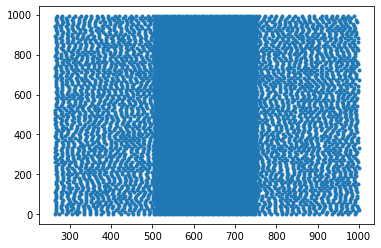

In [12]:
from matplotlib import pyplot
pyplot.plot(events["times"], events["senders"], '.')

In [13]:
neurons

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 1

In [14]:
! nest-server stop

/usr/bin/sh: 1: /opt/nest/bin/nest-server: not found


In [15]:
ray.shutdown()